# Homework 2: Language Models and Neural Networks
#### Introduction to Natural Language Processing

*Yevin, Kim. (kyevin@students.uni-mainz.de)
Hyerin, Seo. (hyseo@students.uni-mainz.de) Yeonwoo, Nam. (yeonam@students.uni-mainz.de)*

You can reach 20 points on this homework.

In this homework we're going to be looking at the bigram language model and extend it to trigrams.

We'll re-visit the sentiment analysis problem from the first homework. This dataset contains a split of unlabeled movie reviews. We'll train our language model using this unlabeled split (i.e., we'll pretrain our language model) and then we'll use this model as a starting off point for a neural classification model (i.e., finetuning), which we'll use to do sentiment classification. Finally, we'll replace our trained embeddings with Glove pretrained vectors, to see if we get any improvement.

This Homework is going to **heavily rely on PyTorch**. I recommend reading into a simple tutorial on how to train a machine learning model with PyTorch. If you have questions, you can reach out via mail: minhducbui@uni-mainz.de

## Section 1: Neural Language Modeling

We'll first load the unsupervised data. Set the data dir below to the directory you used for Homework 1, to prevent copying the data twice.

In [1]:
import os, random, sys, matplotlib.pyplot as plt
import torch, torch.nn as nn, numpy
from nltk.tokenize import word_tokenize

In [2]:
# Make sure that this folder referes to your data folder!!
data_dir = 'aclImdb/'
data_limit = 15000

def read_folder(folder):
    examples = []
    file_names = os.listdir(folder)
    # Sort the file names
    sorted_file_names = sorted(file_names, key=lambda x: int(x.split("_")[0]))  
    for fname in sorted_file_names[:data_limit]:
        with open(os.path.join(folder, fname), encoding='utf8') as f:
            examples.append(f.readline().strip())

    return examples

unsup_examples = read_folder(os.path.join(data_dir, 'train/unsup/'))

The dataset also comes with a pre-made vocabulary, which we'll rely on for this section of the homework. We'll eventually convert our words to indices, so lets store the words in a dictionary, mapping each to a unique integer.

In [27]:
vocabulary_file = os.path.join(data_dir, 'imdb.vocab')

raw_vocabulary = []
with open(vocabulary_file, 'r', encoding='utf8') as f:
    for line in f:
        raw_vocabulary.append(line.strip())

#Limit our vocabulary size to top 5k words
raw_vocabulary = raw_vocabulary[:5000]

# Add in our special tokens
special_tokens = ['<s>', '</s>', '<unk>']

'''
TASK 1:
Your code here.

Create the vocabulary dictionary by prepending the special tokens to the raw vocabulary, and give each token an index.

{'<s>': 0,
 '</s>': 1,
 '<unk>': 2,
 'the': 3,
 'and': 4,
 'a': 5,
 ...


1 pts.

'''
# 어휘 사전 생성
# 특별 토큰과 raw 어휘를 이용하여 각 토큰에 인덱스를 할당
vocabulary = {token: idx for idx, token in enumerate(special_tokens + raw_vocabulary)}

# 어휘 사전의 처음 몇 개 항목을 출력
print(vocabulary)

{'<s>': 0, '</s>': 1, '<unk>': 2, 'the': 3, 'and': 4, 'a': 5, 'of': 6, 'to': 7, 'is': 8, 'it': 9, 'in': 10, 'i': 11, 'this': 12, 'that': 13, 'was': 14, 'as': 15, 'for': 16, 'with': 17, 'movie': 18, 'but': 19, 'film': 20, 'on': 21, 'not': 22, 'you': 23, 'he': 24, 'are': 25, 'his': 26, 'have': 27, 'be': 28, 'one': 29, '!': 30, 'all': 31, 'at': 32, 'by': 33, 'an': 34, 'who': 35, 'they': 36, 'from': 37, 'so': 38, 'like': 39, 'there': 40, 'her': 41, 'or': 42, 'just': 43, 'about': 44, 'if': 45, 'has': 46, 'out': 47, 'what': 48, '?': 49, 'some': 50, 'good': 51, 'more': 52, 'when': 53, 'she': 54, 'very': 55, 'even': 56, 'my': 57, 'no': 58, 'up': 59, 'time': 60, 'would': 61, 'which': 62, 'only': 63, 'story': 64, 'really': 65, 'their': 66, 'see': 67, 'had': 68, 'can': 69, 'were': 70, 'me': 71, 'we': 72, 'than': 73, 'well': 74, 'much': 75, 'been': 76, 'get': 77, 'people': 78, 'will': 79, 'bad': 80, 'other': 81, 'also': 82, 'into': 83, 'do': 84, 'because': 85, 'great': 86, 'first': 87, 'how': 88, 

In [4]:
assert isinstance(vocabulary, dict)
assert len(vocabulary) == 5003
assert vocabulary['<s>'] == 0
assert vocabulary['significance'] == 5002


Now that we have a vocabulary, we can process the unsupervised examples we loaded earlier into actual training data our model can read.

First, we'll tokenize the text normally:

In [28]:
"""
This block may take a while (<5 minutes) to run, but you only have to run it once, so make sure you don't modify the tokenized_examples list after it's completed.
While you're writing your code, consider limiting unsup_examples to the first 5 examples as a smoke test before you run the loop over all examples
"""

from nltk.tokenize import word_tokenize

tokenized_examples = []
sos_id = vocabulary['<s>'] #start of sequence
eos_id = vocabulary['</s>'] #end of sequence
unk_id = vocabulary['<unk>'] # Unknown sequence. Use this, if a token is not in vocab.

for example in unsup_examples:
    example_tokens = [token.lower() for token in word_tokenize(example)]

    token_ids = [sos_id]
    for token in example_tokens:
        # 어휘 사전에 토큰이 있으면 해당 토큰의 인덱스를 추가
        if token in vocabulary:
            token_ids.append(vocabulary[token])
        # 어휘 사전에 토큰이 없으면 <unk> 토큰의 인덱스를 추가 
        else:
            token_ids.append(unk_id)

        '''
        TASK 2:
        Your code here.

        The above loop iterates over the tokens in a single example. 
        If a token is in our vocabulary, then add the index to token_ids. 
        If not, add the unknown token index.
        
        1 pts.

        '''
        
            
    token_ids.append(eos_id)
    tokenized_examples.append(token_ids)

In [29]:
assert len(tokenized_examples[0]) == 191
assert tokenized_examples[0] == [0, 11, 940, 2, 3, 86, 2091, 6, 107, 618, 158, 134, 2, 25, 43, 22, 16, 71, 2, 6, 3, 2587, 42, 38, 2, 653, 2, 2, 11, 27, 2361, 2, 29, 11, 440, 2, 3, 2260, 2, 2, 4, 108, 70, 55, 51, 2, 3, 229, 4300, 4, 522, 2648, 2, 13, 1517, 3053, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 38, 11, 14, 2, 44, 12, 29, 2, 4, 468, 8, 388, 854, 7, 1103, 2, 2, 2, 345, 2, 2738, 294, 2, 11, 120, 39, 3, 471, 154, 2, 19, 201, 115, 6, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 29, 1731, 695, 2, 387, 21, 2, 3, 473, 25, 410, 7, 77, 2, 2, 2, 4, 16, 44, 291, 228, 2, 1300, 1796, 2, 84, 50, 2, 2, 10, 3, 943, 2, 367, 291, 2587, 334, 1320, 33, 2, 31, 1267, 2, 444, 4, 323, 2, 2, 49, 2, 2, 4, 16, 90, 2, 66, 2, 2, 173, 42, 377, 2, 2, 25, 598, 2, 14, 12, 34, 387, 2, 6, 2, 2, 6, 1951, 2, 49, 1]

Now we can create our bigram data. We'll make use of the torch Dataset class. We only need to implement the `__getitem__` and `__len__` methods to make this work with other existing torch tools.

For this dataset, for each example, iterate over its bigrams. If either one of the tokens is an unknown token, then do not save the bigram. Since we're using a small vocabulary, we'll have a lot of unknowns, and we don't want our model to always predict this token as the most likely next token.

Note that with a normal sized vocabulary, training set, and model, you wouldn't necessarily want to do this -- unknowns would hopefully be relatively rare.

In [30]:
import torch

class BigramDataset(torch.utils.data.Dataset):

    def __init__(self, tokenized_data):

        self.examples = [] # add the input here
        for example in tokenized_data:              #Iterate over our dataset
            for i in range(0,len(example) - 1):     #Iterate over the tokens of the example
                '''
                TASK 3:
                Your code here.

                Bigrams should be a tuple of integers: (example[i], example[i+1])
                For each bigram, if either of example[i] or example[i+1] are unknown then do not add the bigram to our examples.

                2 pts.
                '''
                token1 = example[i]
                token2 = example[i+1]
                
                # 확인: 둘 다 알려진 토큰일 때만 추가
                if token != unk_id and token2 != unk_id: 
                    self.examples.append((token1, token2))

    def __getitem__(self, idx):

        return self.examples[idx]

    def __len__(self):

        return len(self.examples)




Now we'll define the bigram model. This is similar to the one in class: the input is a single token, and the model outputs a probability over the whole vocabulary.

In [8]:
import torch.nn as nn

class BigramLM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_hidden_layers):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_layer_1 = nn.Linear(embedding_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers - 1)]
        )
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

        self.relu = nn.ReLU()

    def forward(self, input):

        embedding = self.embedding(input)

        hidden = self.relu(self.hidden_layer_1(embedding))

        for layer in self.hidden_layers:
            hidden = self.relu(layer(hidden))

        output = self.output_layer(hidden)

        return output

Now we'll train the model.

**Before Executing, see the task below!!**

In [9]:
# Training Loop

#Initialize our model -- keep it small with 1 hidden layer, and embedding sizes of 50
bigram_model = BigramLM(len(vocabulary), 50, 50, 1)

#Initialize our dataset using a subset of examples
bigram_dataset = BigramDataset(tokenized_examples[:5000])

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(bigram_model.parameters())            #AdamW is a popularly used optimizer
# optimizer = torch.optim.SGD(bigram_model.parameters(), lr=0.5)    #Either of these optimizers could be used

softmax = nn.Softmax(dim=2)

epochs = 1
batch_size = 32
print_frequency = 1000

# average_losses 배열 정의
average_losses = []

#We'll create an instance of a torch dataloader to collate our data. This class handles batching and shuffling (should be done each epoch)
train_dataloader = torch.utils.data.DataLoader(bigram_dataset, batch_size=batch_size, shuffle=True)

for i in range(epochs):
    print('### Epoch: ' + str(i+1) + ' ###')

    bigram_model.train()
    avg_loss = 0

    for step, data in enumerate(train_dataloader):

        x, y = data
        x = x.unsqueeze(1)

        optimizer.zero_grad()

        model_output = bigram_model(x)
        model_output_probabilities = softmax(model_output)

        loss = criteria(model_output_probabilities.squeeze(1), y)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        
        if step % print_frequency == 0 and step != 0:
            # Add average loss to the list before resetting it
            average_losses.append(avg_loss / print_frequency)  #배열에 average_losses 추가
            print('epoch: {} batch: {} loss: {}'.format(
                i,
                step,
                avg_loss / print_frequency
            ))
            avg_loss = 0

### Epoch: 1 ###
epoch: 0 batch: 1000 loss: 8.463403866767884
epoch: 0 batch: 2000 loss: 8.431225940704346
epoch: 0 batch: 3000 loss: 8.419567486763
epoch: 0 batch: 4000 loss: 8.414731502532959
epoch: 0 batch: 5000 loss: 8.413338192939758
epoch: 0 batch: 6000 loss: 8.411739051818847
epoch: 0 batch: 7000 loss: 8.41240810775757
epoch: 0 batch: 8000 loss: 8.407305716514587
epoch: 0 batch: 9000 loss: 8.408306272506714
epoch: 0 batch: 10000 loss: 8.408471320152282
epoch: 0 batch: 11000 loss: 8.406583477020265
epoch: 0 batch: 12000 loss: 8.406818120002747
epoch: 0 batch: 13000 loss: 8.40550769519806
epoch: 0 batch: 14000 loss: 8.40678869342804
epoch: 0 batch: 15000 loss: 8.403124430656433
epoch: 0 batch: 16000 loss: 8.401692317008973
epoch: 0 batch: 17000 loss: 8.403947978973388
epoch: 0 batch: 18000 loss: 8.403377277374268
epoch: 0 batch: 19000 loss: 8.402172793388367
epoch: 0 batch: 20000 loss: 8.399339826583862
epoch: 0 batch: 21000 loss: 8.401190791130066
epoch: 0 batch: 22000 loss: 8.39

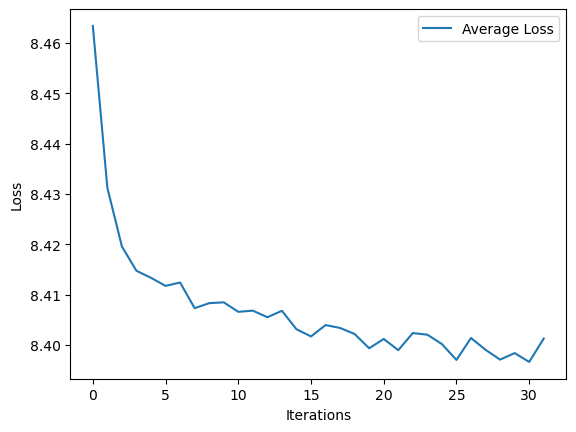

In [10]:
'''
TASK 4: 
Your code here (and modify above).

Use the loop above to train the model for at least 1 epoch.
Modify the loop to keep track of the average loss before it's reset.
(The average loss is reset after print_frequency iterations. Before it's set to 0, store it in a list that will persist throughout training.)

Then, plot the losses using matplotlib (x-axis=Iterations, y-axis=Loss).

2 pts.

'''

# 그래프 생성
plt.plot(range(len(average_losses)), average_losses, label='Average Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# With the trained Bigram model, you can write your own text!
# OPTIONAL: Predict a word sequence beginning with walk



# This was my implementation:

words = ['walk']

for i in range(10):
    word = words[i]
    idx = vocabulary[word]
    tensor_idx = torch.tensor([[idx]])  # Convert the index to a tensor and shape it as (1, 1, dim)

    with torch.no_grad():  # Use no_grad to prevent unnecessary gradient computation
        raw_output = bigram_model(tensor_idx)

    probs = softmax(raw_output) 

    pred = torch.argmax(probs).item()  # Get the predicted index as an integer

    # Print prediction.
    predicted_word = [w for w, v in vocabulary.items() if v == pred][0]
    print(word + ' ' + predicted_word)
    words.append(predicted_word)

walk and
and the
the movie
movie is
is the
the movie
movie is
is the
the movie
movie is


Now we'll modify our model and dataset to create a trigram language model. Here, the input will be two words rather than 1. The output will remain the same.

Hint: since we have two inputs, we'll want to combine them in some way after we get their embeddings. An easy way to do this would be to concatenate the two embeddings together, creating a new vector of size 2*embedding_dim. This will be the input size of the first hidden dimension.

In [33]:
'''
TASK 5:

Your code here.

The input of the dataset will be two words rather than 1.
E.g. one example = ((token1, token2), target_token)
As above, ignore unknown tokens/words.

3 pts.

'''

class TrigramDataset(torch.utils.data.Dataset):

    def __init__(self, tokenized_data):
        self.examples = []
        
        # Trigram 저장
        for example in tokenized_data:
            for i in range(0, len(example) -2):
                token1 = example[i]
                token2 = example[i+1]
                target_token = example[i+2]

                # 모든 토큰이 알려진 토큰인지 확인
                if token1 != unk_id and token2 != unk_id and target_token != unk_id:
                    self.examples.append(((token1, token2), target_token))

    def __getitem__(self, idx):
        return self.examples[idx]

    def __len__(self):

        return len(self.examples)

In [34]:
'''
TASK 6:

Since we have two inputs, we'll want to combine them in some way after we get their embeddings. 
An easy way to do this would be to concatenate the two embeddings together, creating a new vector of size 2*embedding_dim. 
This will be the input size of the first hidden dimension.
Make sure that the dimensions of this cell and the following cell match!

3 pts.

'''

class TrigramLM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_hidden_layers):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #임베딩 서로 연결
        self.embedding_dim = 2 * embedding_dim
        
        self.hidden_layer_1 = nn.Linear(self.embedding_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers - 1)]
        )
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

        self.relu = nn.ReLU()

    def forward(self, input_1, input_2):
        # Hint: we'll need to get an embedding for our second input somehow
        # self.embedding_1 = self.embedding(input_1)
        # self.embedding_2 =
        
        #두 inputs에 대한 임베딩 가져오기
        embedding_1 = self.embedding(input_1)
        embedding_2 = self.embedding(input_2)

        # 임베딩을 {embedding_dim}을 따라 연결
        combined_embedding = torch.cat([embedding_1, embedding_2], dim = -1)

        # 연결된 임베딩을 첫 번째 은닉 계층을 통과시킴
        hidden_output = self.relu(self.hidden_layer_1(combined_embedding))

        # 나머지 은닉 계층을 통과시킴
        for layer in self.hidden_layers:
            hidden_output = self.relu(layer(hidden_output))
        
        # Hint: This might be one way to combine our embeddings
        # self.embedding = torch.cat()

        output = self.output_layer(hidden_output)

        return output

In [14]:
def train_trigram(trigram_model, trigram_dataset):

    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(trigram_model.parameters())
    # optimizer = torch.optim.SGD(trigram_model.parameters(), lr=0.5)

    softmax = nn.Softmax(dim=2)

    epochs = 1
    batch_size = 32
    print_frequency = 1000


    train_dataloader = torch.utils.data.DataLoader(trigram_dataset, batch_size=batch_size, shuffle=True)

    for i in range(epochs):
        print('### Epoch: ' + str(i+1) + ' ###')

        trigram_model.train()
        avg_loss = 0

        for step, data in enumerate(train_dataloader):

            x, y = data
            '''
            
            Make sure that dimensions of your input are taken care of!!
            
            '''

            x_1 = x[0].unsqueeze(1)
            x_2 = x[1].unsqueeze(1)

            optimizer.zero_grad()

            model_output = trigram_model(x_1, x_2)
            model_output_probabilities = softmax(model_output)
            loss = criteria(model_output_probabilities.squeeze(1), y)

            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if step % print_frequency == 0 and step != 0:
                print('epoch: {} batch: {} loss: {}'.format(
                    i,
                    step,
                    avg_loss / print_frequency
                ))
                avg_loss = 0

In [15]:
"""
TASK 7:

Complete the following code block by initializing the model/dataset and training for at least one epoch
Hint: the models and dataset should be _extremely_ similar to the bigram model and dataset

2 pts.
"""

#trigram model 초기화
trigram_model = TrigramLM(len(vocabulary), 50, 50, 1)

#예제 일부 사용하여 trigram dataset 초기화 
trigram_dataset = TrigramDataset(tokenized_examples[:5000])

#trigram model 트레이닝
train_trigram(trigram_model, trigram_dataset)


### Epoch: 1 ###
epoch: 0 batch: 1000 loss: 8.458235622406006
epoch: 0 batch: 2000 loss: 8.423399940490723
epoch: 0 batch: 3000 loss: 8.414165298461914
epoch: 0 batch: 4000 loss: 8.409467324256896
epoch: 0 batch: 5000 loss: 8.405786259651183
epoch: 0 batch: 6000 loss: 8.402210989952087
epoch: 0 batch: 7000 loss: 8.400106241226196
epoch: 0 batch: 8000 loss: 8.398070444107056
epoch: 0 batch: 9000 loss: 8.399045994758605
epoch: 0 batch: 10000 loss: 8.396060368537903
epoch: 0 batch: 11000 loss: 8.396421692848206
epoch: 0 batch: 12000 loss: 8.396470300674439
epoch: 0 batch: 13000 loss: 8.393725329399109
epoch: 0 batch: 14000 loss: 8.391245515823364
epoch: 0 batch: 15000 loss: 8.392373896598816
epoch: 0 batch: 16000 loss: 8.394101424217224
epoch: 0 batch: 17000 loss: 8.392340001106263
epoch: 0 batch: 18000 loss: 8.39481984615326
epoch: 0 batch: 19000 loss: 8.392341394424438


To complete this section, complete the Trigram model and dataset, and train the model for at least 1 epoch.

In [16]:
# OPTIONAL: Predict a word sequence beginning with walk with your trigram
# Your Code here (OPTIONAL)

## Section 2: Sentiment Analysis

In this section we'll compare how a neural model similar to the one above performs on sentiment analysis. Then, we'll replace the embeddings with pretrained ones to see if that increases our performance. To make our life easier, we'll use the glove vocabulary for both models.



- Use it from Homework 02 or download the embeddings from here: https://nlp.stanford.edu/projects/glove/. ALTERNATIVE (if download is slow): Just google "6B 50d GloVe"

The glove vectors are distributed as a text file, with the word in the first column, and the embeddings in the remaining columns. We'll read in the embeddings here.

In [17]:
glove_file = 'glove.6B.50d.txt'

embeddings_dict = {}

with open(glove_file, 'r', encoding='utf8') as f:
    for i, line in enumerate(f):
        if i == 0:
            print(line)
        line = line.strip().split(' ')
        word = line[0]
        embed = numpy.asarray(line[1:], "float")

        embeddings_dict[word] = embed

print('Loaded {} words from glove'.format(len(embeddings_dict)))

embedding_matrix = numpy.zeros((len(embeddings_dict)+1, 50)) #add 1 for padding

word2id = {}
for i, word in enumerate(embeddings_dict.keys()):

    word2id[word] = i                                #Map each word to an index
    embedding_matrix[i] = embeddings_dict[word]      #That index holds the Glove embedding in the embedding matrix

# Our joint vocabulary for both models / sanity check to see if we've loaded it correctly:
print(word2id['the'])
print(embedding_matrix[word2id['the']])

word2id['<pad>'] = embedding_matrix.shape[0] - 1
print(embedding_matrix[word2id['<pad>']])


the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581

Loaded 400000 words from glove
0
[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.47

We'll create another dataset for our (now labeled) movie reviews. Do not change the max_length values.

In [18]:
# Create a classification dataset for the movie reviews


class MovieReviewDataset(torch.utils.data.Dataset):

    def __init__(self, directory=None, split=None, word2id=None, finalized_data=None, data_limit=250, max_length=256):
        """
        :param directory: The location of aclImdb
        :param split: Train or test
        :param word2id: The generated glove word2id dictionary
        :param finalized_data: We'll use this to initialize a validation set without reloading the data.
        :param data_limit: Limiter on the number of examples we load
        :param max_length: Maximum length of the sequence
        """

        self.data_limit = data_limit
        self.max_length = max_length
        self.word2id = word2id

        if finalized_data:
            self.data = finalized_data

        else:

            pos_dir = directory + '{}/pos/'.format(split)
            neg_dir = directory + '{}/neg/'.format(split)

            pos_examples = self.read_folder(pos_dir)
            neg_examples = self.read_folder(neg_dir)

            pos_examples_tokenized = [(ids, 1) for ids in self.tokenize(pos_examples)]
            neg_examples_tokenized = [(ids, 0) for ids in self.tokenize(neg_examples)]

            self.data = pos_examples_tokenized + neg_examples_tokenized

            random.shuffle(self.data)

    def read_folder(self, folder):
        examples = []
        for fname in os.listdir(folder)[:self.data_limit]:
            with open(os.path.join(folder, fname), encoding='utf8') as f:
                examples.append(f.readline().strip())
        return examples

    def tokenize(self, examples):

        example_ids = []
        misses = 0              # Count the number of tokens in our dataset which are not covered by glove -- i.e. percentage of unk tokens
        total = 0
        for example in examples:
            tokens = word_tokenize(example)
            ids = []
            for tok in tokens:
                if tok in word2id:
                    ids.append(word2id[tok])
                else:
                    misses += 1
                    ids.append(word2id['unk'])
                total += 1

            if len(ids) >= self.max_length:
                ids = ids[:self.max_length]
            else:
                ids = ids + [word2id['<pad>']]*(self.max_length - len(ids))
            example_ids.append(torch.tensor(ids))
        print('Missed {} out of {} words -- {:.2f}%'.format(misses, total, misses/total))
        return example_ids

    def generate_validation_split(self, ratio=0.8):

        split_idx = int(ratio * len(self.data))

        # Take a chunk of the processed data, and return it in order to initialize a validation dataset
        validation_split = self.data[split_idx:]

        #We'll remove this data from the training data to prevent leakage
        self.data = self.data[:split_idx]

        return validation_split


    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)


We'll define our two models: the randomly initialized RandomModel and the GloveModel where we use the pretrained vectors.

In [19]:
# Define a simple classification model
class RandomModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_hidden_layers, max_length=256):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_layer_1 = nn.Linear(embedding_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers - 1)]
        )


        self.output_layer = nn.Linear(hidden_dim, 1)

        self.relu = nn.ReLU()

    def forward(self, input):

        embedding = self.embedding(input).squeeze(1)
        embedding = torch.sum(embedding, dim=1)

        hidden = self.relu(self.hidden_layer_1(embedding))
        for layer in self.hidden_layers:
            hidden = self.relu(layer(hidden))

        output = self.output_layer(hidden)
        return output

# Define a Glove classification model
class GloveModel(nn.Module):

    def __init__(self, pretrained_embedding, hidden_dim, num_hidden_layers, max_length=256):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(pretrained_embedding))
        self.hidden_layer_1 = nn.Linear(pretrained_embedding.shape[1], hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers - 1)]
        )
        self.output_layer = nn.Linear(hidden_dim, 1)

        self.relu = nn.ReLU()

    def forward(self, input):

        embedding = self.embedding(input).squeeze(1)
        embedding = torch.sum(embedding, dim=1)

        hidden = self.relu(self.hidden_layer_1(embedding))
        for layer in self.hidden_layers:
            hidden = self.relu(layer(hidden))

        output = self.output_layer(hidden)

        return output

Here we'll define a new prediction method. It will take the output of the model and classify it as 0 if it's below the threshold (0.5) or 1 otherwise.

We'll use this method to log our validation accuracy as we train.

In [20]:
def predict(model, valid_dataloader):

    sigmoid = nn.Sigmoid()

    total_correct = 0
    total_examples = len(valid_dataloader)

    for x,y in valid_dataloader:

        x = x.unsqueeze(1)
        output = sigmoid(model(x))

        if (output < 0.5 and y == 0) or (output >= 0.5 and y == 1):
            total_correct += 1

    accuracy = total_correct / total_examples
    print('accuracy: {}'.format(accuracy))
    return accuracy

Finally, we'll define the training loop for these models.

In [21]:
def train_classification(model, train_dataset, valid_dataset, epochs=100, batch_size=32, print_frequency=100):

    criteria = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters())            
    
    # You can use these variables
    
    train_losses = []  # To collect training losses
    valid_accuracies = []  # To collect validation accuracies
    
    epochs = epochs
    batch_size = batch_size
    print_frequency = print_frequency

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False)

    for i in range(epochs):
        print('### Epoch: ' + str(i+1) + ' ###')

        model.train()
        avg_loss = 0

        for step, data in enumerate(train_dataloader):

            x, y = data
            x = x.unsqueeze(1)

            optimizer.zero_grad()

            model_output = model(x)

            loss = criteria(model_output.squeeze(1), y.float())

            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            
        # 평균 손실 계산 및 저장
        avg_loss /= len(train_dataloader)
        train_losses.append(avg_loss)

        model.eval()
        with torch.no_grad():
            #유효성 검사 정확도를 예측하는 함수가 있다고 가정
            valid_accuracy = predict(model, valid_dataloader)
            valid_accuracies.append(valid_accuracy)
            
        # 다른 관련 정보를 출력하거나 저장
    return train_losses, valid_accuracies

Initialize the training and validation datasets/dataloaders

In [22]:
# Here you can experiment with the data_limit!
train_dataset = MovieReviewDataset(data_dir, 'train', word2id)
validation_examples = train_dataset.generate_validation_split()
print('Loaded {} train examples'.format(train_dataset.__len__()))

valid_dataset = MovieReviewDataset(finalized_data=validation_examples, word2id=word2id)
print('Loaded {} validation examples'.format(valid_dataset.__len__()))

Missed 8659 out of 71710 words -- 0.12%
Missed 8502 out of 70085 words -- 0.12%
Loaded 400 train examples
Loaded 100 validation examples


In the following two code blocks, initialize a new RandomModel in one, and a new GloveModel in the other -- use train_classification() to train them. For each model, find a set of model parameters (i.e. play around with the number of hidden layers and the hidden layer size) and training parameters (epochs, batch size) which give you a good (>70) validation accuracy.

Some tips:

    1. Given your resources, first try and prioritize how many data examples you load. This is controlled by the data_limit value of the dataset.
    
    2. For previous models, we've only trained for 1-3 epochs due to the large number of parameters when language modeling. You may need to train for a considerably longer time (>30-50 epochs) to get results
    
    3. Performance is both a function of training time and the model itself. Keep an eye on the validation accuracy in case the model is overfitting (can be prevented by using more examples)
    
    4. Right now, every hidden layer is the same dimension. Consider widening or narrowing some layers. 

Additionally, modify the training loop to collect validation set accuracies after each epoch (the predict method is already returning these values). For each model, plot the training loss and validation accuracy over time.

### Epoch: 1 ###
accuracy: 0.57
### Epoch: 2 ###
accuracy: 0.62
### Epoch: 3 ###
accuracy: 0.53
### Epoch: 4 ###
accuracy: 0.53
### Epoch: 5 ###
accuracy: 0.56
### Epoch: 6 ###
accuracy: 0.58
### Epoch: 7 ###
accuracy: 0.57
### Epoch: 8 ###
accuracy: 0.59
### Epoch: 9 ###
accuracy: 0.58
### Epoch: 10 ###
accuracy: 0.61
### Epoch: 11 ###
accuracy: 0.63
### Epoch: 12 ###
accuracy: 0.59
### Epoch: 13 ###
accuracy: 0.58
### Epoch: 14 ###
accuracy: 0.66
### Epoch: 15 ###
accuracy: 0.61
### Epoch: 16 ###
accuracy: 0.59
### Epoch: 17 ###
accuracy: 0.58
### Epoch: 18 ###
accuracy: 0.61
### Epoch: 19 ###
accuracy: 0.64
### Epoch: 20 ###
accuracy: 0.65
### Epoch: 21 ###
accuracy: 0.67
### Epoch: 22 ###
accuracy: 0.63
### Epoch: 23 ###
accuracy: 0.61
### Epoch: 24 ###
accuracy: 0.65
### Epoch: 25 ###
accuracy: 0.6
### Epoch: 26 ###
accuracy: 0.65
### Epoch: 27 ###
accuracy: 0.62
### Epoch: 28 ###
accuracy: 0.63
### Epoch: 29 ###
accuracy: 0.65
### Epoch: 30 ###
accuracy: 0.62


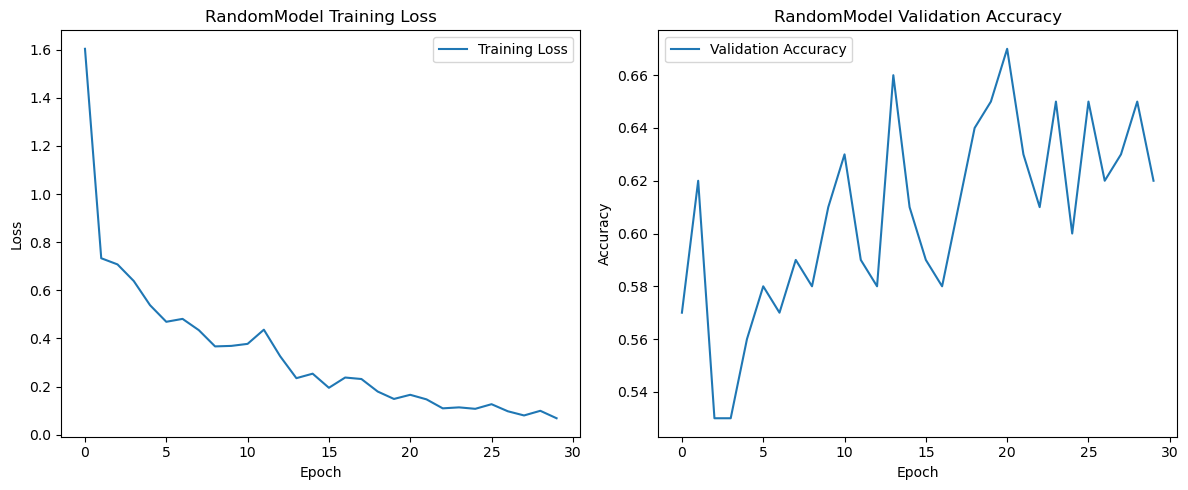

In [23]:
'''
Initialize the RandomModel here.

Additionally, modify the training loop (train_classification) to collect training loss and validation set accuracies after each **epoch** 
(the predict method is already returning these values). 
Plot the training loss and validation accuracy over time (epoch).

Your code here (and above)

3 pts.
'''
random_model = RandomModel(vocab_size=len(word2id), embedding_dim=50, hidden_dim=64, num_hidden_layers=2)

# RandomModel 훈련
train_losses_random, valid_accuracies_random = train_classification(random_model, train_dataset, valid_dataset, epochs=30, batch_size=32)

# 훈련 손실과 검증 정확도 시간에 따라 플로팅
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_random, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RandomModel Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valid_accuracies_random, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RandomModel Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Epoch: 1 ###
accuracy: 0.53
### Epoch: 2 ###
accuracy: 0.58
### Epoch: 3 ###
accuracy: 0.6
### Epoch: 4 ###
accuracy: 0.69
### Epoch: 5 ###
accuracy: 0.68
### Epoch: 6 ###
accuracy: 0.69
### Epoch: 7 ###
accuracy: 0.63
### Epoch: 8 ###
accuracy: 0.63
### Epoch: 9 ###
accuracy: 0.72
### Epoch: 10 ###
accuracy: 0.66
### Epoch: 11 ###
accuracy: 0.71
### Epoch: 12 ###
accuracy: 0.68
### Epoch: 13 ###
accuracy: 0.64
### Epoch: 14 ###
accuracy: 0.75
### Epoch: 15 ###
accuracy: 0.7
### Epoch: 16 ###
accuracy: 0.72
### Epoch: 17 ###
accuracy: 0.72
### Epoch: 18 ###
accuracy: 0.72
### Epoch: 19 ###
accuracy: 0.71
### Epoch: 20 ###
accuracy: 0.7
### Epoch: 21 ###
accuracy: 0.74
### Epoch: 22 ###
accuracy: 0.69
### Epoch: 23 ###
accuracy: 0.75
### Epoch: 24 ###
accuracy: 0.79
### Epoch: 25 ###
accuracy: 0.76
### Epoch: 26 ###
accuracy: 0.73
### Epoch: 27 ###
accuracy: 0.77
### Epoch: 28 ###
accuracy: 0.68
### Epoch: 29 ###
accuracy: 0.72
### Epoch: 30 ###
accuracy: 0.77


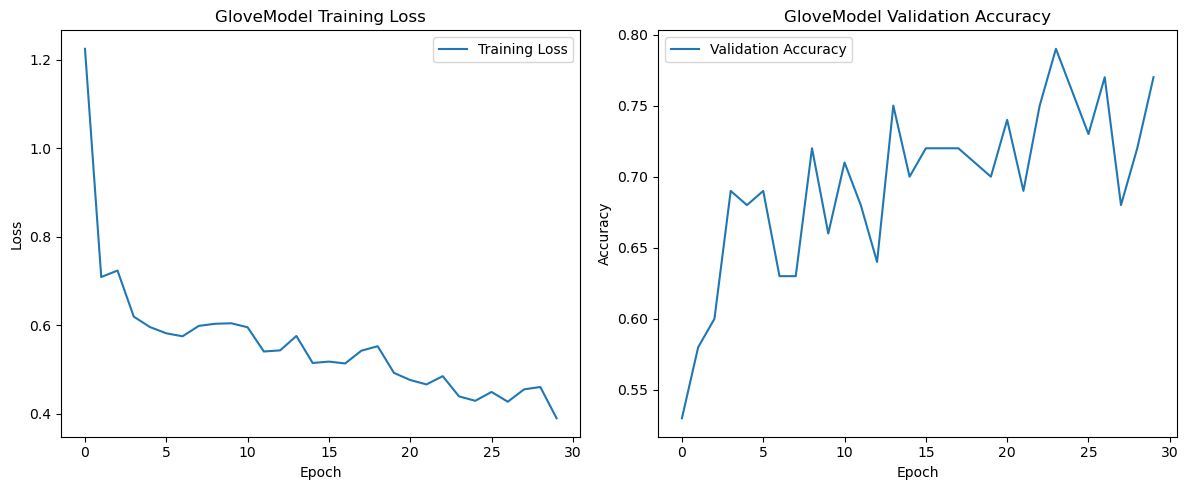

In [24]:
'''

Initialize the GloveModel here.
Plot the training loss and validation accuracy over time (epoch).


Your code here

2 pts.
'''

#GloveModel 초기화
glove_model = GloveModel(pretrained_embedding=embedding_matrix, hidden_dim=64, num_hidden_layers=2)

# GloveModel 트레이닝 # train_classification(glove_model, train_dataset, valid_dataset)
train_losses_glove, valid_accuracies_glove = train_classification(glove_model, train_dataset, valid_dataset, epochs=30, batch_size=32)

# 훈련 손실과 검증 정확도 시간에 따라 플로팅
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_glove, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GloveModel Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valid_accuracies_glove, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GloveModel Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Once you've finished tuning parameters, test the two models on the test set.

In [25]:
test_dataset = MovieReviewDataset(data_dir, 'test', word2id)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

print('Random model accuracy: ')
predict(random_model, test_dataloader)

print('Glove model accuracy: ')
predict(glove_model, test_dataloader)

Missed 9821 out of 74122 words -- 0.13%
Missed 7515 out of 66371 words -- 0.11%
Random model accuracy: 
accuracy: 0.604
Glove model accuracy: 
accuracy: 0.688


0.688

## Free Response Questions:
1. Compare the performance of the Glove model vs the Random model. Refer to the validation accuracy curves and the test set results in your answer. (1P)
2. Compare the training loop between the supervised and unsupervised models. What's different (outside of code features like predicting validation accuracy after each epoch)? (2P)

1. Both the Glove model and the Random model show a trend of increasing validation accuracy over epochs. Validation accuracy is not significantly different between the Glove model and the Random model. However, the accuracy in the test set is 60.4% for the Random model and 68.8% for the Glove model, indicating that the Glove model is more accurate.

2. The validatoin accuracy of the Glove model, which is a supervised model, is steadily above 0.6 from about epoch 3 and often above 0.7 from epoch 9. On the other hand, the Random model, an unsupervised model, does not stably achieve an accuracy of 0.6 or higher until epoch 18. In other words, the supervised model uses input data and corresponding labels to train the model, so the accuracy increases relatively quickly, while the unsupervised model uses unlabeled data and requires relatively many epochs to draw inferences from the dataset. Therefore, we can see that the accuracy increases relatively slowly. As a result, this also affects the test on the test set, and the accuracy of the supervised learning Glove model is higher.
